In [1]:
# this is a tutorial from Kaggle to use sklearn pipelines in kaggle housing data set
# Personally, I'm not sure if I agree with everything that is done here,
# Especially the fact that ALL columns are used: is that a good thing?

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [8,8]

In [10]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [11]:
# From analysis we know that OverallQual and GrLivArea are decent
# Maybe for educational purposes we should try to find a decent categorical variable?
# It should probably be neighborhood at some point, but it is a tricky one, we need to try
# to reduce number of categories
# Idea: Define neighborhoods on average SalePrice to determine whether it's a 'affluent' 'mid' or 'low' neighborhood
# You could actually do a k-means of neighborhoods using sale price. That would be quite interesting to try later on!
# :)

In [12]:
# Splitting train set from test set using sklearn function for that
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop('SalePrice',axis = 1),
                                                    train_data['SalePrice'],
                                                    test_size = 0.3,
                                                    random_state = 0) 

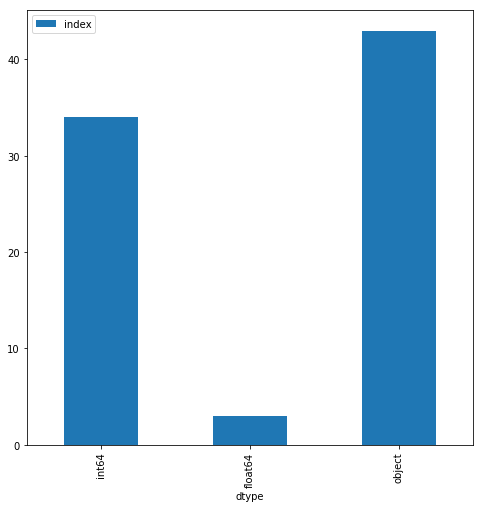

In [14]:
# This is a cool function: It first creates a pd.DataFrame of all dtype, then counts by dtype, 
# and creates a barplot of it. 
pd.DataFrame(X_train.dtypes.values, columns=['dtype']).reset_index().groupby('dtype').count().plot(kind='bar')

In [15]:
# so based on this you can say our pipeline needs to be able to handle numerical AND categorical data.
# The idea is then that you build separate pipelines for each of these types, and then merge /(Union) them togeter 
# at the end.

In [16]:
# using Jan Koch's pipelines. 
# Let us briefly describe how transformers are used:

# If the transformer needs to remember the state of the training data, 
# e.g. the mean of a column, the fit method 
# is used on the training data to store this state. 
# Subsequently, the transform function is used on the train and test data. 
# However, if not state preservation is needed, 
# e.g. in the case of log transforming data, the fit functions may essentially do nothing, 
# and we just use the transform function. Note that the fit function is never used on the test data

In [17]:
# basically, you have a lot of pipelines from sklearn, and you can build them yourself
# using TransformerMixin and BaseEstimator.
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline, make_pipeline

In [18]:
class SelectColumnsTransformer(TransformerMixin,BaseEstimator):
    
    """ A DataFrame transformer that provides column selection
    
    Allows to select columns by name from pandas dataframes in scikit-learn
    pipelines.
    
    Parameters
    ----------
    columns : list of str, names of the dataframe columns to select
        Default: [] 
    
    """
    
    def __init__(self, columns = []):
        self.columns = columns
    
    def transform(self, X, **transform_params):
        
        """ Selects columns of a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
            
        Returns
        ----------
        
        trans : pandas DataFrame
            contains selected columns of X
            
        Max: Note that this is a transform: it has to be applied to train AND test set, and nothing has to be 'stored'
        (like the mean for example)
        
        Also you want to make a copy, else the indices can still be manipulated under another name, which is fucked
        """
        trans = X[self.columns].copy() 
        return trans
    
    def fit(self, X, y = None,**fit_params):
        """ Do nothing function
        
        Parameters
        ----------
        X : pandas DataFrame
        y : default None
                
        
        Returns
        ----------
        self  
        """
        return self
    

In [19]:
# pipeline wrapper for applying a function:
# or an imputation: It seems to me an imputation is like, normalising. 
# I'm not sure where the float number is returned

class DataFrameFunctionTransformer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer providing imputation or function application
    
    Parameters
    ----------
    impute : Boolean, default False
        
    func : function that acts on an array of the form [n_elements, 1]
        if impute is True, functions must return a float number, otherwise 
        an array of the form [n_elements, 1]
    
    """
    
    def __init__(self, func, impute = False):
        self.func = func
        self.impute = impute
        self.series = pd.Series() 

    def transform(self, X, **transformparams):
        """ Transforms a DataFrame
        
        Parameters
        ----------
        X : DataFrame
            
        Returns
        ----------
        trans : pandas DataFrame
            Transformation of X 
        """
        
        if self.impute:
            trans = pd.DataFrame(X).fillna(self.series).copy()
        else:
            trans = pd.DataFrame(X).apply(self.func).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Fixes the values to impute or does nothing
        
        Parameters
        ----------
        X : pandas DataFrame
        y : not used, API requirement
                
        Returns
        ----------
        self  
        """
        
        if self.impute:
            self.series = pd.DataFrame(X).apply(self.func).copy()
        return self

In [20]:
class DataFrameFeatureUnion(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that unites several DataFrame transformers
    
    Fit several DataFrame transformers and provides a concatenated
    Data Frame
    
    Parameters
    ----------
    list_of_transformers : list of DataFrameTransformers
        
    """ 
    def __init__(self, list_of_transformers):
        self.list_of_transformers = list_of_transformers
        
    def transform(self, X, **transformparamn):
        """ Applies the fitted transformers on a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
        
        Returns
        ----------
        concatted :  pandas DataFrame
        
        """
        
        concatted = pd.concat([transformer.transform(X)
                            for transformer in
                            self.fitted_transformers_], axis=1).copy()
        return concatted


    def fit(self, X, y=None, **fitparams):
        """ Fits several DataFrame Transformers
        
        Parameters
        ----------
        X : pandas DataFrame
        y : not used, API requirement
        
        Returns
        ----------
        self : object
        """
        
        self.fitted_transformers_ = []
        for transformer in self.list_of_transformers:
            fitted_trans = clone(transformer).fit(X, y=None, **fitparams)
            self.fitted_transformers_.append(fitted_trans)
        return self

In [21]:
# one hot encoder I suppose
class ToDummiesTransformer(BaseEstimator, TransformerMixin):
    """ A Dataframe transformer that provide dummy variable encoding
    """
    
    def transform(self, X, **transformparams):
        """ Returns a dummy variable encoded version of a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
        
        Returns
        ----------
        trans : pandas DataFrame
        
        """
    
        trans = pd.get_dummies(X).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Do nothing operation
        
        Returns
        ----------
        self : object
        """
        return self

In [22]:
# okay, drop all zero columns.
# I suppose you could also drop columns with a certain fraction of nulls in them.
# Is it best practice to start with pipelines right away? Not sure
class DropAllZeroTrainColumnsTransformer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that provides dropping all-zero columns
    """

    def transform(self, X, **transformparams):
        """ Drops certain all-zero columns of X
        
        Parameters
        ----------
        X : DataFrame
        
        Returns
        ----------
        trans : DataFrame
        """
        
        trans = X.drop(self.cols_, axis=1).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Determines the all-zero columns of X
        
        Parameters
        ----------
        X : DataFrame
        y : not used
        
        Returns
        ----------
        self : object
        """
        
        self.cols_ = X.columns[(X==0).all()]
        return self

In [23]:
# The next step is to construct pipelines for sets of columns, depending on what you want
# (?i) starts case-insensitive mode, | is of course the 'or' operator
area_cols = X_train.columns[X_train.columns.str.contains('(?i)area|(?i)porch|(?i)sf')].tolist()

In [26]:
# make_pipeline is just shorthand to create a Pipeline.
# so in this one we take the log of the area (apparently they are all skewed, check in analysis notebook)
# impute just means fill the missing values with something. In this case we fill it with the mean.
# after filling we simply take the log.
# if you want to check the pipeline, you can see it actually does make sense.
# You could think about constructing the pipelines differently (why not have a special remove_nulls pipeline anyway?)
# To me it seems you're taking too many columns at once. 

area_cols_pipeline = make_pipeline(  
        SelectColumnsTransformer(area_cols),
        DataFrameFunctionTransformer(func = lambda x: x.astype(np.float64)),
        DataFrameFunctionTransformer(func = np.mean, impute=True), # so impute is true since we use the other stuff
        DataFrameFunctionTransformer(func = np.log1p))

In [27]:
# object columns can be taken by filtering [X_train.dtype]

object_columns = X_train.columns[X_train.dtypes == object].tolist() # pretty neat that this works
object_levels = np.union1d(X_train[object_columns].fillna('NAN'), X_test[object_columns].fillna('NAN'))

categorical_cols_pipeline = make_pipeline(
        SelectColumnsTransformer(object_columns),
        DataFrameFunctionTransformer(lambda x:'NAN', impute=True),
        DataFrameFunctionTransformer(lambda x:x.astype('category', categories=object_levels)),
        ToDummiesTransformer(),
        DropAllZeroTrainColumnsTransformer())

In [28]:
# I mean this just takes all the columns: but would you want that really? like Alley is just shit.
object_columns = X_train.columns[X_train.dtypes == object].tolist()
object_levels = np.union1d(X_train[object_columns].fillna('NAN'), X_test[object_columns].fillna('NAN'))

categorical_cols_pipeline = make_pipeline(
        SelectColumnsTransformer(object_columns),
        DataFrameFunctionTransformer(lambda x:'NAN', impute=True),
        DataFrameFunctionTransformer(lambda x:x.astype('category', categories=object_levels)),
        ToDummiesTransformer(),
        DropAllZeroTrainColumnsTransformer())

In [29]:
# remaining cols: transform to float64 and all that. also replace nulls with the mean.
# (like the quality I suppose: is that a good idea?)
remaining_cols = [x for x in X_train.columns.tolist() if x not in object_columns and x not in area_cols]

remaining_cols_pipeline = make_pipeline(
        SelectColumnsTransformer(remaining_cols),
        DataFrameFunctionTransformer(func = lambda x: x.astype(np.float64)),
        DataFrameFunctionTransformer(func = np.mean, impute=True)
    )

In [30]:
# I suppose we now union the shit out of it?
preprocessing_features = DataFrameFeatureUnion([area_cols_pipeline, categorical_cols_pipeline, remaining_cols_pipeline])
preprocessing_features.fit_transform(X_train).head()


,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MiscVal,MoSold,YrSold
64,9.145909,6.352629,6.606650,0.0,5.765191,6.964136,6.964136,6.885510,0.0,7.618251,...,1.0,3.0,1.0,8.0,0.0,1998.000000,2.0,0.0,2.0,2009.0
682,7.968320,0.000000,6.911747,0.0,5.666427,7.163947,7.163947,0.000000,0.0,7.163947,...,0.0,2.0,1.0,6.0,1.0,1996.000000,2.0,0.0,11.0,2008.0
960,8.882947,0.000000,6.546785,0.0,5.093750,6.755769,6.755769,0.000000,0.0,6.755769,...,0.0,2.0,1.0,4.0,0.0,1978.012397,0.0,0.0,2.0,2010.0
1384,9.111735,0.000000,5.323010,0.0,5.877736,6.329721,6.549651,6.329721,0.0,7.138073,...,0.0,2.0,1.0,6.0,0.0,1939.000000,1.0,0.0,10.0,2009.0
1100,9.036106,0.000000,5.673323,0.0,0.000000,5.673323,6.084499,0.000000,0.0,6.084499,...,0.0,1.0,1.0,3.0,0.0,1930.000000,1.0,0.0,1.0,2009.0


In [31]:
# use ridge regression combined with grid search, cross validations and cross_val_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
pipe_ridge = make_pipeline(preprocessing_features, Ridge())
param_grid = {'ridge__alpha' : [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}
pipe_ridge_gs = GridSearchCV(pipe_ridge, param_grid=param_grid, scoring = 'neg_mean_squared_error', cv=3)
result = np.sqrt(-cross_val_score(pipe_ridge_gs, X_train, np.log(y_train), scoring = 'neg_mean_squared_error', cv = 5))
np.mean(result)

0.12528930481048564

In [32]:
# so this is an example of a pipeline
# but rly, does it make sense to use ALL the columns?
help(clone)

Help on function clone in module sklearn.base:

clone(estimator, safe=True)
    Constructs a new estimator with the same parameters.
    
    Clone does a deep copy of the model in an estimator
    without actually copying attached data. It yields a new estimator
    with the same parameters that has not been fit on any data.
    
    Parameters
    ----------
    estimator : estimator object, or list, tuple or set of objects
        The estimator or group of estimators to be cloned
    
    safe : boolean, optional
        If safe is false, clone will fall back to a deep copy on objects
        that are not estimators.

